## Modelling

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

dat_2012 = pd.read_csv("./data_2012.csv").iloc[:,1:]
dat_2016 = pd.read_csv("./data_2016.csv").iloc[:,1:]
dat_2020 = pd.read_csv("./data_2020.csv").iloc[:,1:]

dat_2012 = dat_2012.set_index("CD_ID")
dat_2016 = dat_2016.set_index("CD_ID")
dat_2020 = dat_2020.set_index("CD_ID")

In [3]:
# set some pandas viewing options
pd.set_option("display.max_columns",100)

In [4]:
# sneak peek at what one row looks like
dat_2012.ix["AK-AL"]

Democrat                                                                  41.2
Republican                                                                55.3
P_Democrat                                                                38.1
P_Republican                                                              59.7
Pop                                                                     722718
Females                                                                 349802
Median_Age                                                                33.9
Veterans                                                                 72407
White_People                                                            482698
Afr_Am_People                                                            23143
Asian                                                                    37971
American_Ind_Alk_Ntv                                                    102293
Cuban_Origin                                        

In [5]:
# attach the state latitude and longitude to make state a usable column
state = pd.read_csv("state_latlong.csv")
state.columns = ["State_Full", "Latitude","Longitude"]

dat_2012 = dat_2012.merge(state, on='State_Full').set_index(dat_2012.index)
dat_2016 = dat_2016.merge(state, on='State_Full').set_index(dat_2016.index)
dat_2020 = dat_2020.merge(state, on='State_Full').set_index(dat_2020.index)

In [6]:
# define dropped columns
dropped_columns = ["CD",
                   "State_Full",
                   "State",
                   "State_Id",
                   "Vote_2012",
                   "Vote_2016",
                   "Vote_2020",
                   "Ticket_CD_Demo",
                   "District_Name"]

### Initial baseline model

In [7]:
# merge two dataframes together without dropping any columns 
# first since they have the same number of columns
merged = pd.concat((dat_2012, dat_2016))

In [8]:
# dropping columns that are hard to deal with(for now)

# drop selected columns from above
merged = merged.drop(columns=dropped_columns)

In [9]:
# standardize the dataset for every column except Democrat and Republican
# such that each feature is centered at 0 and with variance 1

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from feature_engineering import *


feature, label = process_features(merged)


sc = StandardScaler()

# dataset is now divided into feature, which is a standardized feature set
# and label, which consists of republican and democrat percentages
# the percentages will be converted to decimal form to make it into a probability set

feature, label = shuffle(feature, label)

In [10]:
# testing several baseline, untuned models to get a sense of 
# accuracy that can be achieved without too much tuning
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from cv_score_model import *

# models being tried
svm = SVR(gamma=10)
xgb = XGBRegressor(n_jobs=-1, verbosity=0)
gbt = GradientBoostingRegressor()
lm = Ridge(alpha=0.0001)
ridge = Ridge(alpha=0.0001)
lasso = Lasso(alpha=0.0001)

cv_score_model(lasso, feature, label)

mean cross-validation error for democrat is:  7.548030141042275
rmse for democrat is around:  2.7473678568845266
mean cross-validation error for republican is:  10.817445447976512
rmse for republican is around:  3.2889885144184543
mean cross-validation error for difference is:  34.204238547911224
rmse for difference is around:  5.848438983858105


### Validation

In [11]:
# Validation of results by doing the same approach using xgb with 2016 data with 2012 data
from validation import *

xgb = XGBRegressor(n_jobs=-1, verbosity=0, learning_rate=0.1, n_estimators=100)

validation(xgb, dropped_columns,preprocessor=[sc])

mean cross-validation error for democrat is:  5.791383714957346
rmse for democrat is around:  2.4065293920825788
mean cross-validation error for republican is:  5.257744989618714
rmse for republican is around:  2.2929773199093604
mean cross-validation error for difference is:  21.589793515970236
rmse for difference is around:  4.64648184285382


test error on democrat on 2016 data is:  23.492047859299056
root test error on democrat on 2016 data is:  4.846859587330652
test error on republican on 2016 data is:  26.522047621506925
root test error on republican on 2016 data is:  5.149956079570672
test error on democrat on 2016 data is:  81.98403690196312
root test error on difference on 2016 data is:  9.054503680598021


In [12]:
# Validation of results by doing the same approach using lasso regression with 2016 data with 2012 data
from validation import validation

validation(lasso, dropped_columns,preprocessor=[sc])

mean cross-validation error for democrat is:  68.78452246636775
rmse for democrat is around:  8.29364349766541
mean cross-validation error for republican is:  71.3725944756994
rmse for republican is around:  8.448230257024212
mean cross-validation error for difference is:  282.6898969384955
rmse for difference is around:  16.813384458177822


test error on democrat on 2016 data is:  19.806626909222246
root test error on democrat on 2016 data is:  4.4504636735088905
test error on republican on 2016 data is:  25.749016281359847
root test error on republican on 2016 data is:  5.074348852942597
test error on democrat on 2016 data is:  72.36401684638619
root test error on difference on 2016 data is:  8.50670422939379


In [13]:
# using feature engineering to further improve the accuracy
from feature_engineering import *

val_train_X, val_train_Y = process_features(dat_2012)

val_test_X, val_test_Y = process_features(dat_2016)

val_train_X = pd.DataFrame(val_train_X, 
                           index=val_train_X.index,
                           columns=val_train_X.columns)

val_test_X = pd.DataFrame(val_test_X, 
                           index=val_test_X.index,
                           columns=val_test_X.columns)

In [14]:
#Try lasso, ridge and OLS

lm = Ridge(alpha=0.0001)
ridge = Ridge(alpha=0.0001)
lasso = Lasso(alpha=0.0001)

lasso.fit(val_train_X, val_train_Y.Democrat-val_train_Y.Republican)

np.sqrt(mse(lasso, val_test_X, val_test_Y.Democrat-val_test_Y.Republican))

8.896747117221093

In [15]:
# generate predictions for validation test
lasso_pred = pd.Series(lasso.predict(val_test_X),val_test_X.index)

In [16]:
lasso_pred

CD_ID
TX-27   -18.197570
NE-02    -8.493214
GA-01   -10.582126
VA-10     0.082800
CO-05   -20.060531
           ...    
CA-39     0.765224
WI-07    -6.487768
NC-08    -6.367498
OH-12   -14.156346
MA-08    18.093876
Length: 435, dtype: float64

In [17]:
result = pd.DataFrame((lasso_pred, val_test_Y.Democrat - val_test_Y.Republican)).T
result.columns = ["predicted","actual"]
result["difference"] = result.predicted - result.actual
result["deviance"] = np.abs(result.actual - result.predicted)
result["sign_correct"] = result.actual * result.predicted >0
result.index = val_test_Y.index

In [18]:
# percentage of districts that at least the winner was predicted correctly
print(np.round(result.sign_correct.mean() * 100,1),"% of validation set had the correct winner prediction\n")

print(np.round(np.mean(result.actual>0)*100,1),"% of the validation set had democrats winning")

93.1 % of validation set had the correct winner prediction

47.6 % of the validation set had democrats winning


In [19]:
# check for what districts the cases were really off
result[~result.sign_correct]

,predicted,actual,difference,deviance,sign_correct
CD_ID,,,,,
NJ-02,7.800305,-4.6,12.400305,12.400305,False
NY-18,3.025276,-1.9,4.925276,4.925276,False
IA-02,8.916798,-4.1,13.016798,13.016798,False
NH-01,2.541420,-1.6,4.141420,4.141420,False
ME-02,7.029817,-10.3,17.329817,17.329817,False
AZ-02,-0.088373,4.9,-4.988373,4.988373,False
NY-02,8.245101,-9.1,17.345101,17.345101,False
NJ-07,-6.992211,1.1,-8.092211,8.092211,False
CA-45,-8.981246,5.4,-14.381246,14.381246,False


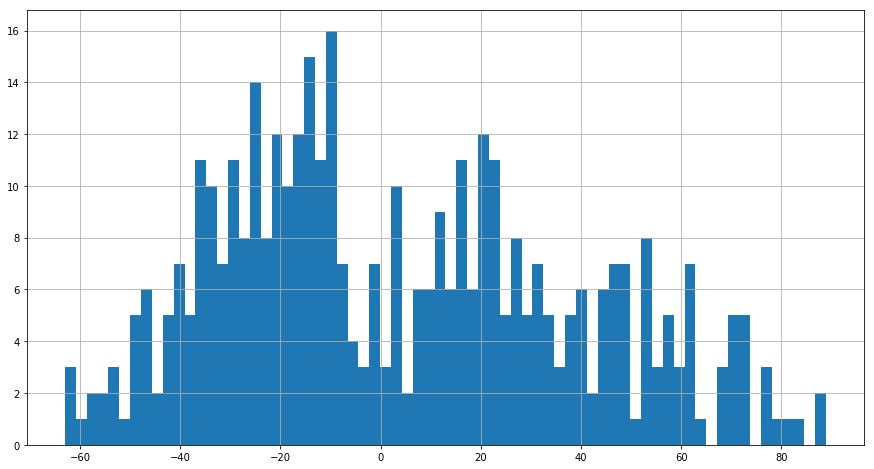

In [20]:
# plot histogram 
result[result.sign_correct].actual.hist(bins=70, figsize=(15,8))

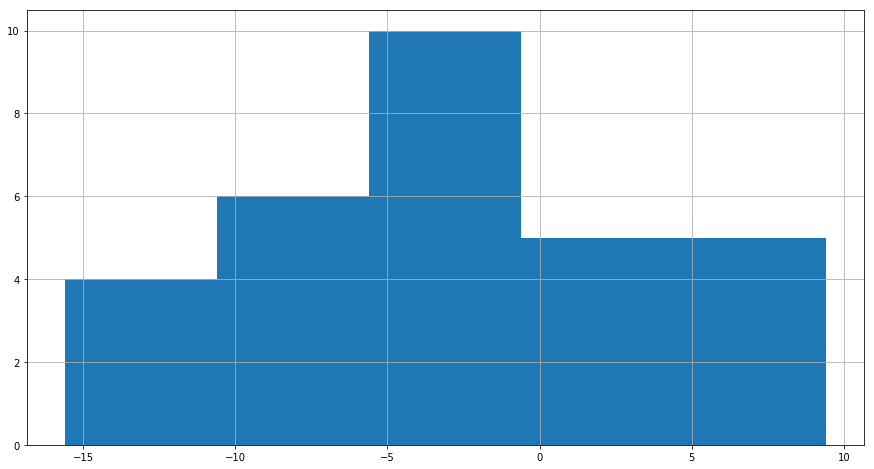

In [21]:
result[~result.sign_correct].actual.hist(bins=5, figsize=(15,8))

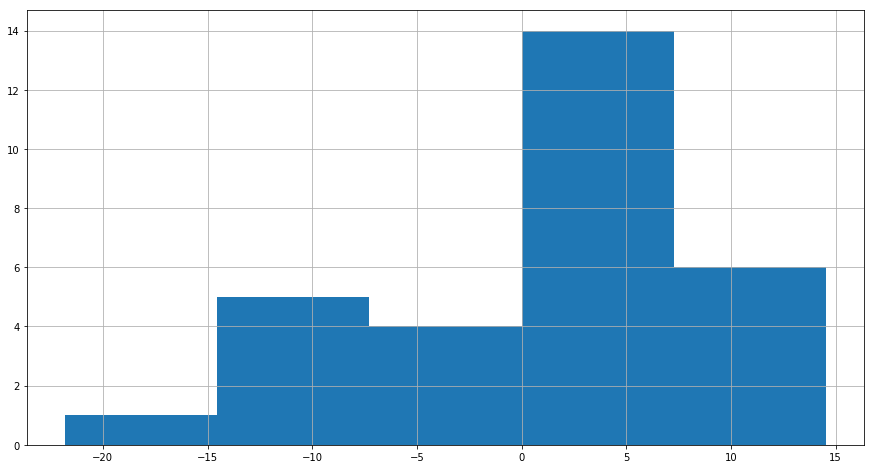

In [22]:
# what were the predictions
plt.figure(figsize=(8,5))
result[~result.sign_correct].predicted.hist(bins=5, figsize=(15,8))

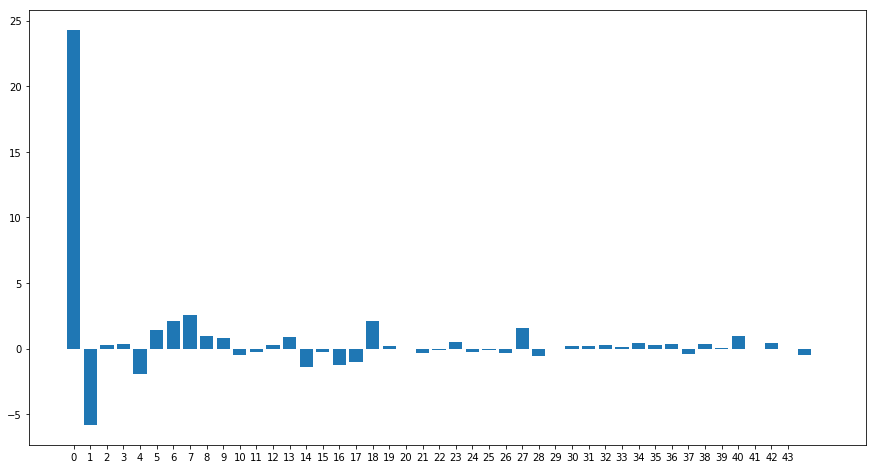

In [23]:
# visualizing the coefficients of the lasso model

plt.figure(figsize=(15,8))
plt.bar(range(len(val_train_X.columns)),lasso.coef_)
plt.xticks(range(44))
plt.show()

In [24]:
sig_analysis = pd.concat((pd.Series(val_train_X.columns),pd.Series(lasso.coef_)), axis=1)
sig_analysis.columns = ["column_name","coefficient"]
sig_analysis["coef_magnitude"] = np.abs(sig_analysis.coefficient)

In [38]:
sig_analysis.sort_values(by='coef_magnitude',ascending=False)

,column_name,coefficient,coef_magnitude
0,P_Democrat,24.303052,24.303052
1,P_Republican,-5.825934,5.825934
7,Afr_Am_People,2.532814,2.532814
6,White_People,2.113056,2.113056
18,Less_Highschool,2.094419,2.094419
4,Median_Age,-1.948850,1.948850
27,Median_Age_Of_Worker,1.594439,1.594439
14,Native_US,-1.432464,1.432464
5,Veterans,1.383034,1.383034
16,Children,-1.229027,1.229027


In [40]:
# https://github.com/slundberg/shap
# SHAP need be installed before running the next cell

!pip install shap

In [26]:
import shap
explainer = shap.KernelExplainer(lasso.predict, val_train_X, link="identity")
shap_values = explainer.shap_values(val_test_X, nsamples=100)

Using 423 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


In [27]:
val_test_X["State"] = val_test_X.index.str[:2]

In [28]:
state_index = {}

for i in np.unique(val_test_X.State):
    temp = np.argwhere(val_test_X.State == i )
    
    temp = [j[0] for j in temp]
    state_index[i] = temp
    
del i, temp

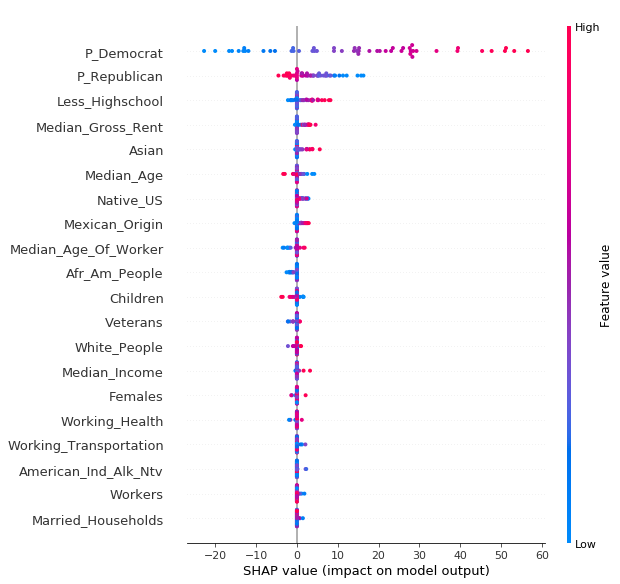

In [29]:
shap.initjs()
state_code="CA"
shap.summary_plot(shap_values[state_index[state_code]],
                val_test_X.iloc[state_index[state_code],:].drop(columns='State'))

### Prediction

In [30]:
###Generating predictions
from feature_engineering import *

lasso.fit(feature, label.Democrat - label.Republican)

test_feature = process_features(dat_2020,is_dat_2020=True)
test_pred_difference = lasso.predict(test_feature)

lasso.fit(feature, label)
test_pred = lasso.predict(test_feature)

In [31]:
final_pred = pd.concat((pd.DataFrame(test_pred_difference),pd.DataFrame(test_pred)),axis=1)
final_pred.columns = ["Difference_predictions","Democrat_predictions","Republican_predictions"]

In [32]:
final_pred.index = test_feature.index

In [33]:
final_pred["State"] = final_pred.index.str[:2]
final_pred

,Difference_predictions,Democrat_predictions,Republican_predictions,State
CD_ID,,,,
IN-06,-41.669641,27.894792,69.572948,IN
NY-22,-19.243526,38.532421,57.779720,NY
CA-01,-23.075933,36.829595,59.890937,CA
CA-39,13.333946,56.164591,42.820701,CA
TX-12,-31.368727,35.589672,66.933146,TX
...,...,...,...,...
IN-08,-34.946538,30.751387,65.717713,IN
OH-06,-51.680053,24.332862,76.014975,OH
RI-02,4.844236,52.224338,47.365816,RI


In [34]:
final_pred.to_csv("predictions_2020.csv")

In [35]:
lasso.fit(feature, label.Democrat - label.Republican)

explainer = shap.KernelExplainer(lasso.predict, test_feature, link="identity")
shap_values = explainer.shap_values(test_feature, nsamples=100)

Using 435 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


In [36]:
state_index_2020 = {}

for i in np.unique(final_pred.State):
    temp = np.argwhere(final_pred.State == i )
    
    temp = [j[0] for j in temp]
    state_index_2020[i] = temp
    
del i, temp

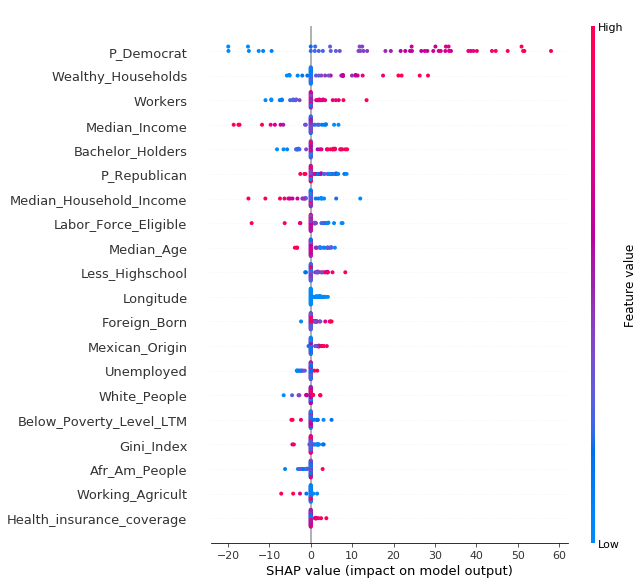

In [37]:
shap.initjs()
state_code = "CA"
shap.summary_plot(shap_values[state_index_2020[state_code]],
                test_feature.iloc[state_index_2020[state_code],:])